In [2355]:
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [2356]:
#import sys
# !conda install --yes --prefix {sys.prefix} -c districtdatalabs yellowbrick
#!conda install --yes --prefix {sys.prefix} -c conda-forge umap-learn

In [2357]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.neighbors import NearestNeighbors

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.metrics import silhouette_score
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

В ДЗ использован датасет https://www.kaggle.com/datasets/uciml/german-credit

In [2358]:
df = pd.read_csv('german_credit_data.csv', sep=';')

In [2359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [2360]:
rows = df.shape[0]
cols = df.shape[1]
numeric_rows = len(df.select_dtypes([np.number]).columns)
print(f'Анализ датасета после работы с признаками: {rows} наблюдений и {cols} признаков, из которых {numeric_rows} - числовых, пропуски данных есть.')

Анализ датасета после работы с признаками: 1000 наблюдений и 9 признаков, из которых 4 - числовых, пропуски данных есть.


In [2361]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [2362]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Пропусков в данных досточно много, удалять наблюдения с пропусками нецелесообразно - останется мало наблюдений, будем заполнять пробелы - пропуски в категориальных признаках, создадим для пропусков отдельную категорию:

In [2363]:
df['Saving accounts'].fillna(value='unknown',inplace=True)
df['Checking account'].fillna(value='unknown',inplace=True)

In [2364]:
df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

Пропуски в данных устранены

In [2365]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


Проверим уникальные признаки по всем категориальным признакам (датасет про Германию, сколько там полов я не уверен )))))):

In [2366]:
categorical_columns = df.select_dtypes(exclude=['number','bool_']).columns.to_list()
categorical_dict = {}
for col in categorical_columns:
    categorical_dict[col] = df[col].value_counts().index.tolist()

In [2367]:
for col in categorical_columns:
    print(df[col].value_counts())
    print('------------------------------------')

male      690
female    310
Name: Sex, dtype: int64
------------------------------------
own     713
rent    179
free    108
Name: Housing, dtype: int64
------------------------------------
little        603
unknown       183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
------------------------------------
unknown     394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64
------------------------------------
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64
------------------------------------


In [2368]:
def feature_plot(feature_name, categorical_feature, categorical_feature_value):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    axes.figure
    for val in categorical_feature_value:
        axes.hist(df[feature_name].loc[df[categorical_feature] == val], 100, alpha=1.0/len(categorical_feature_value), label=val)
    axes.legend(loc='upper right')
    axes.set_title(feature_name)
    plt.tight_layout()
    plt.show()

In [2369]:
for cat_feat in categorical_dict.items():
    for feature in list(df.select_dtypes([np.number]).columns):
        feature_plot(feature, cat_feat[0], cat_feat[1])

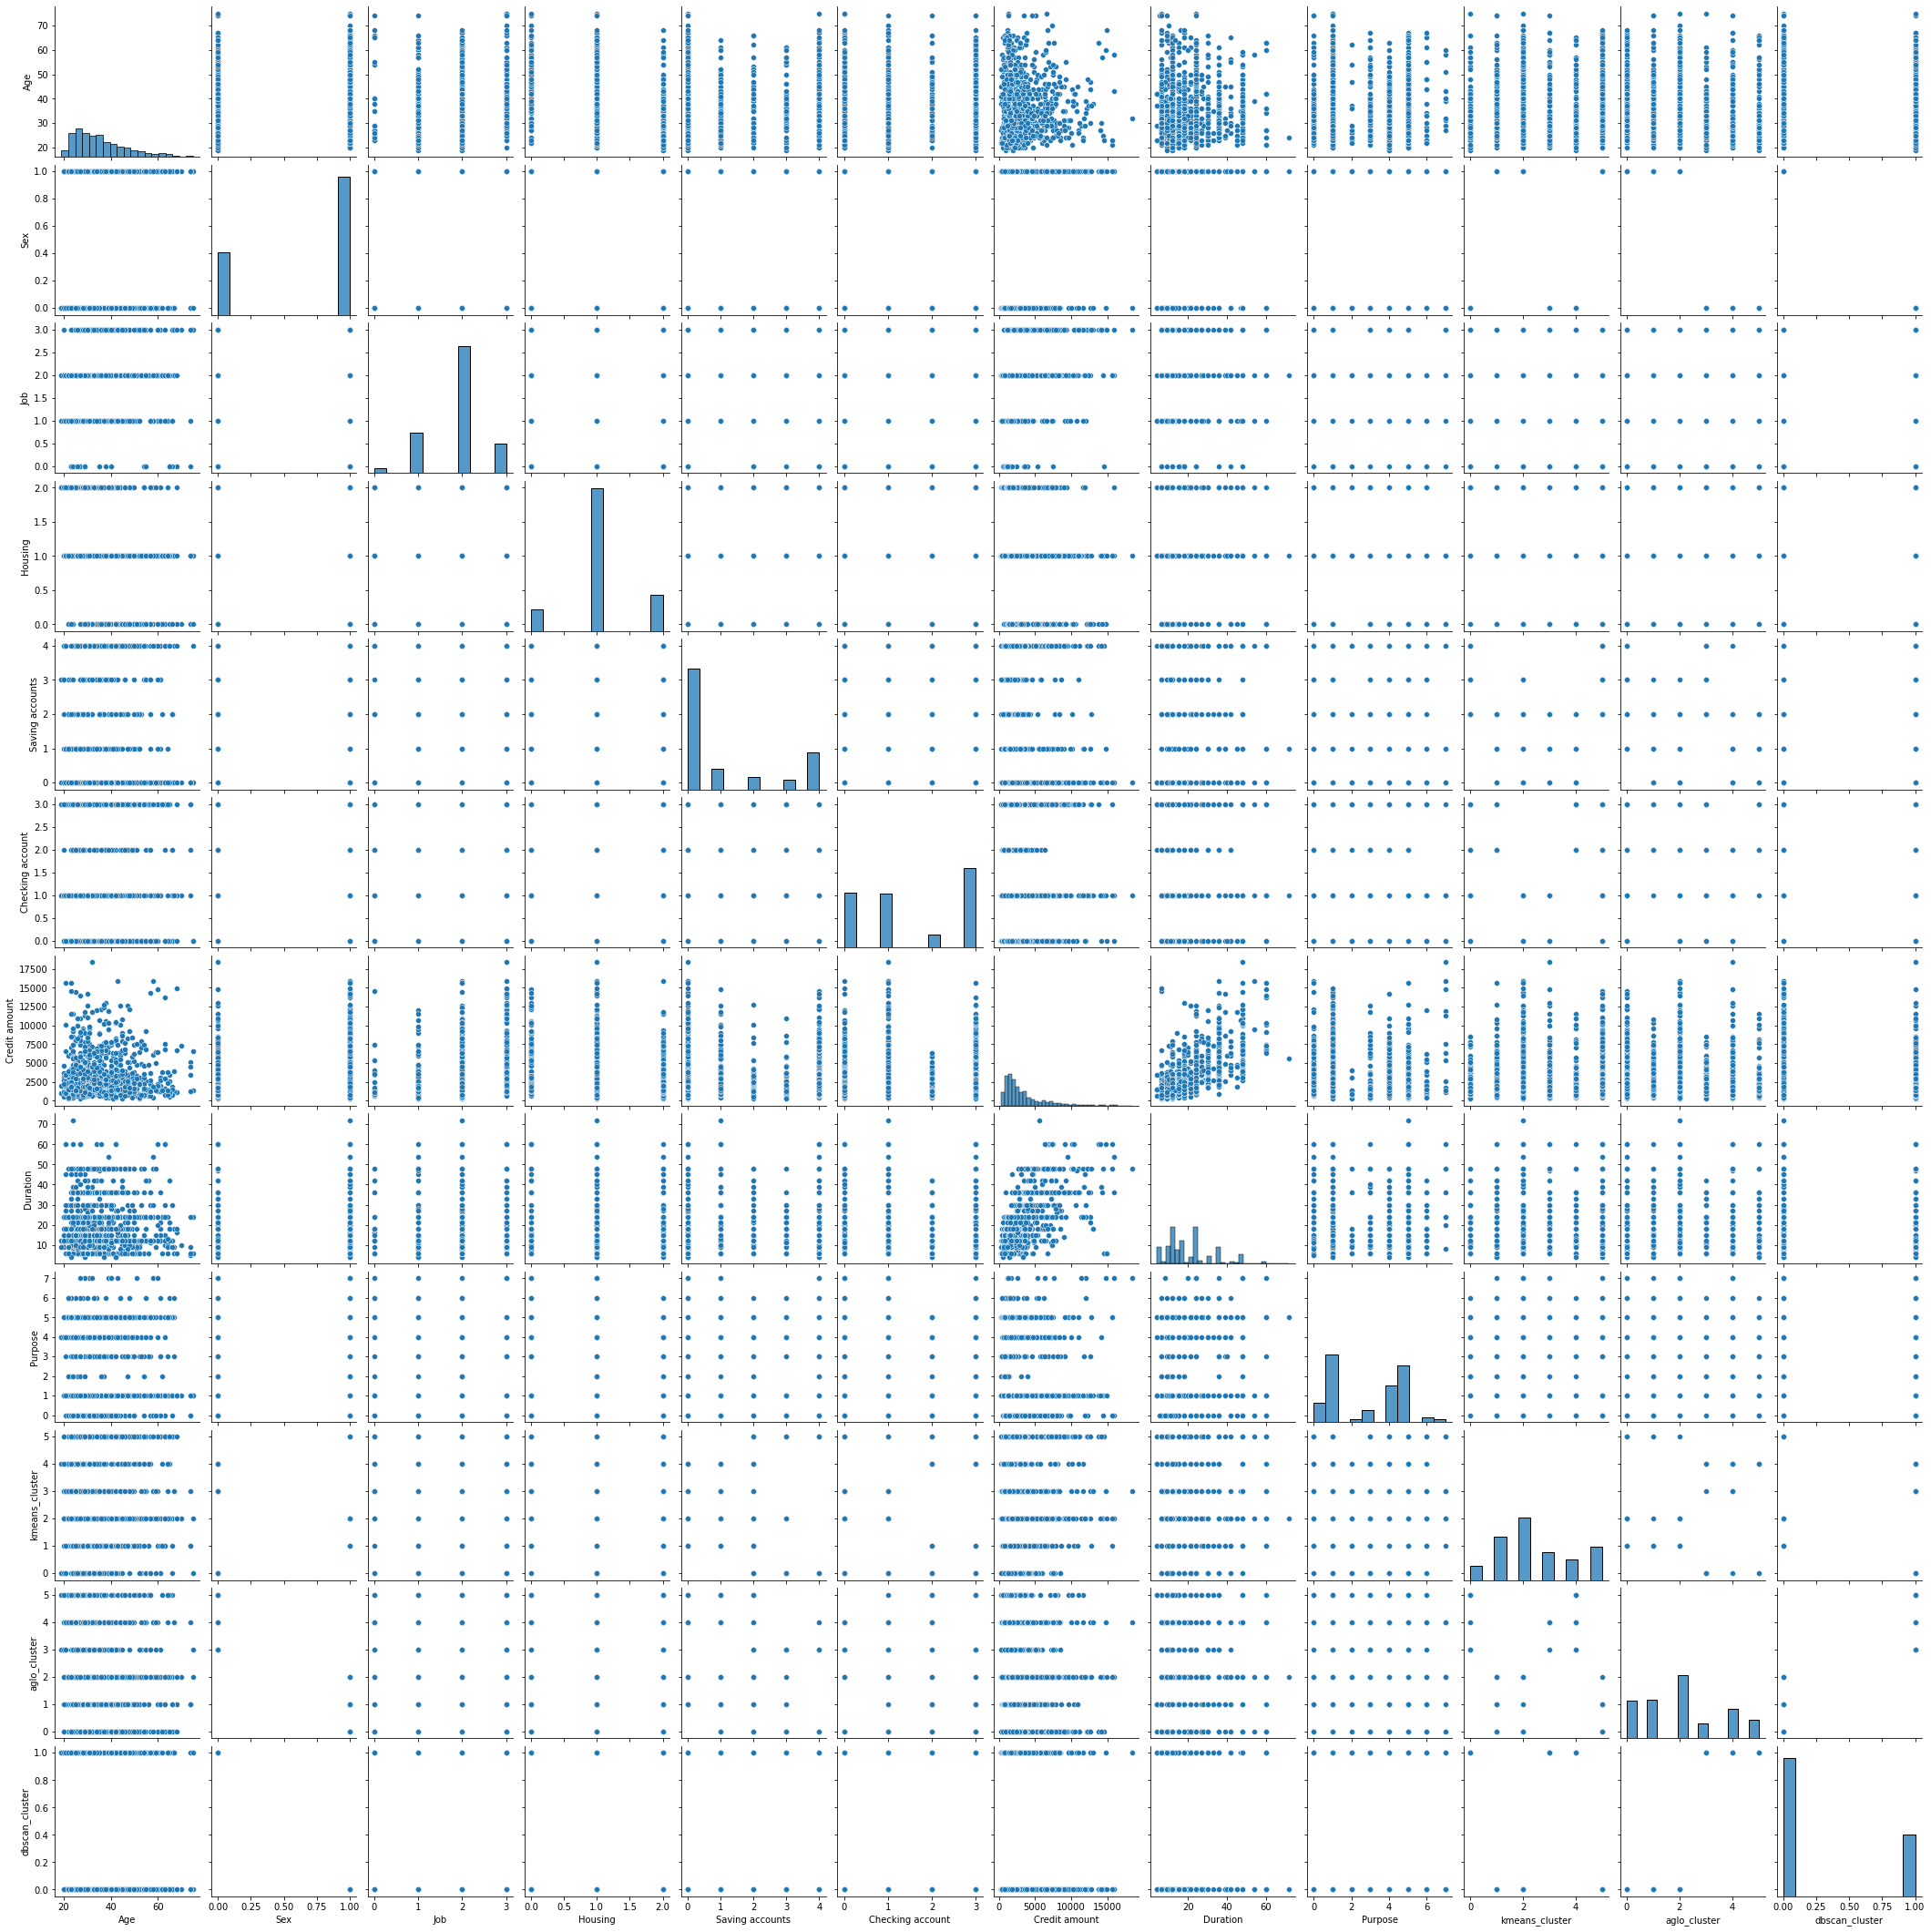

In [2422]:
sns.pairplot(df)
plt.show;

Кодируем признаки согласно условия ДЗ:

In [2370]:
labelencoder = LabelEncoder()
df['Sex'] = labelencoder.fit_transform(df['Sex'])
df['Purpose'] = labelencoder.fit_transform(df['Purpose'])
df['Housing'] = labelencoder.fit_transform(df['Housing'])
df['Saving accounts'] = labelencoder.fit_transform(df['Saving accounts'])
df['Checking account'] = labelencoder.fit_transform(df['Checking account'])

Признаки 'Housing' и 'Purpose' не имеют признаком ранжирования, кодируем их OneHotEncoder:

In [2371]:
min_pts = df.shape[1]

In [2372]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,4,0,1169,6,5
1,22,0,2,1,0,1,5951,48,5
2,49,1,1,1,0,3,2096,12,3
3,45,1,2,0,0,0,7882,42,4
4,53,1,2,0,0,0,4870,24,1


Приводим данные к одному масштабу, что необходимо т.к. при расчете расстояний между объектами - все измерения в пространстве должны быть в одних единицах.

In [2373]:
scaler = MinMaxScaler()  #StandardScaler
scaler = scaler.fit(df)
df_normalized = scaler.fit_transform(df)
df_normalized = pd.DataFrame(df_normalized, columns=df.columns)

In [2374]:
df_normalized.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0.857143,1.0,0.666667,0.5,1.0,0.000000,0.050567,0.029412,0.714286
1,0.053571,0.0,0.666667,0.5,0.0,0.333333,0.313690,0.647059,0.714286
2,0.535714,1.0,0.333333,0.5,0.0,1.000000,0.101574,0.117647,0.428571
3,0.464286,1.0,0.666667,0.0,0.0,0.000000,0.419941,0.558824,0.571429
4,0.607143,1.0,0.666667,0.0,0.0,0.000000,0.254209,0.294118,0.142857


Проводим кластеризацию алгоритмом K-Means:

In [2375]:
def elbow_checker(cluster_model, X):
    sns.reset_orig()
    k_max = 25
    inertia = []
    for k in range(1, k_max):
        kmeans = cluster_model(n_clusters=k).fit(X)
        inertia.append(np.sqrt(kmeans.inertia_))

    plt.figure(figsize=(16, 8))
    plt.plot(range(1, k_max), inertia, marker='x')

    plt.xlabel('Количество кластеров k')
    plt.ylabel('Инерция')
    plt.grid()
    plt.show()

In [2376]:
def silhouette_checker(cluster_model, X):
    k_max = 25
    silhouette = []
    for k in tqdm(range(2, k_max)):
        agg = cluster_model(n_clusters=k).fit(X)
        labels = agg.labels_
        score = silhouette_score(X, labels)
        silhouette.append(score)
    plt.figure(figsize=(16, 8))
    plt.plot(range(2, k_max), silhouette, marker='x');
    plt.grid()

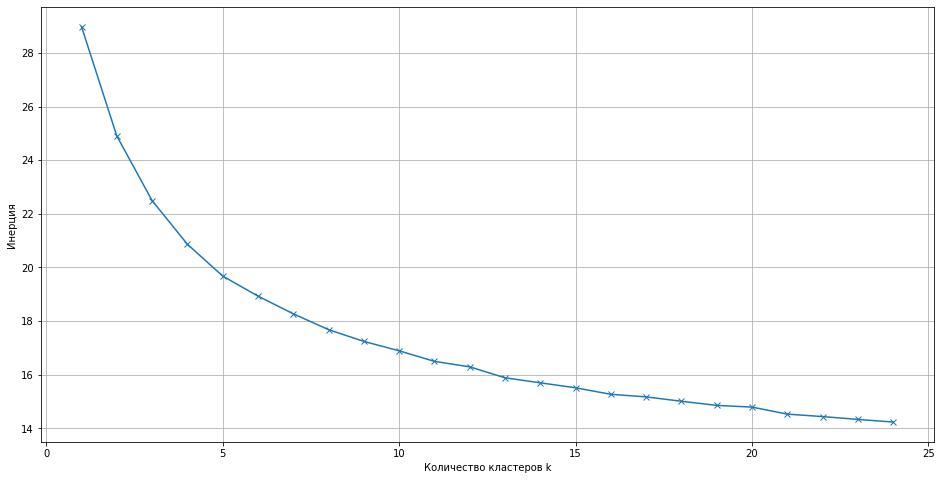

In [2377]:
elbow_checker(KMeans, df_normalized)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.20it/s]


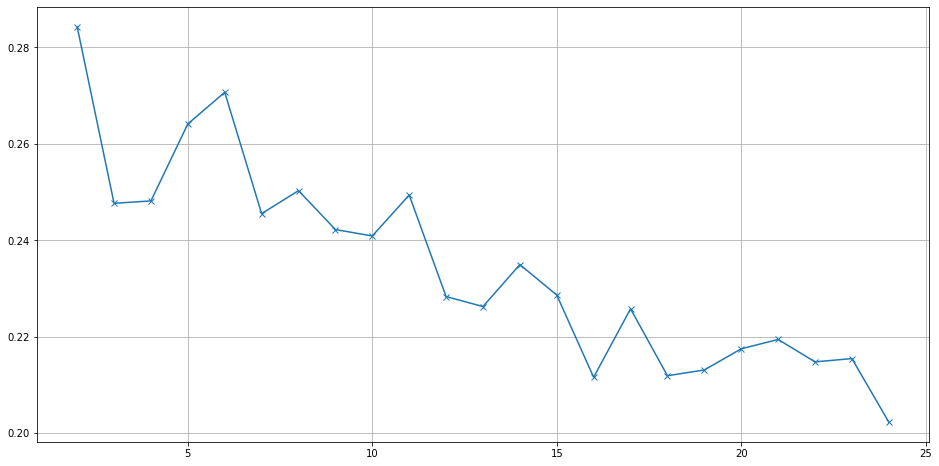

In [2378]:
silhouette_checker(KMeans, df_normalized)

Судя по графикам методов локтя и силуэта, оптимальное количество кластеров - 6, проводим кластеризацию:

In [2379]:
kmeans = KMeans(n_clusters=6, random_state=97)
df_normalized['kmeans_cluster'] = kmeans.fit_predict(df_normalized)

In [2380]:
unique, counts = np.unique(df_normalized['kmeans_cluster'], return_counts=True)
print(f'Количество записей каждого кластера: {dict(zip(unique, counts))}')

Количество записей каждого кластера: {0: 72, 1: 214, 2: 311, 3: 137, 4: 101, 5: 165}


In [2381]:
# plt.figure(figsize=(18, 6))

# plt.scatter(df_normalized[df_normalized.columns[0]], df_normalized[df_normalized.columns[6]], c=df_normalized[df_normalized.columns[-1]], cmap='coolwarm')
# #plt.scatter(df[df.columns[0]], df[df.columns[1]], c=df[df.columns[-1]], cmap='coolwarm')

# plt.title('Кластеризация по сумме и сроку кредита')
# plt.xlabel('Сумма кредита')
# plt.ylabel('Срок кредита')

# plt.show()

Проводим кластеризацию алгоритмом AgglomerativeClustering:

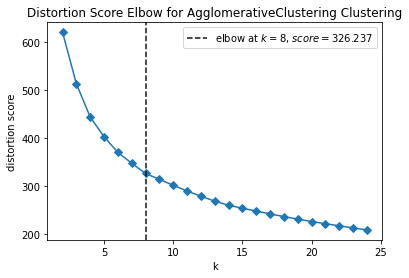

In [2382]:
sns.reset_orig()
visualizer = KElbowVisualizer(aglomer, k=(2, 25), timings=False)
visualizer.fit(df_normalized.drop(columns=['kmeans_cluster'], axis=1))
visualizer.show();

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.65it/s]


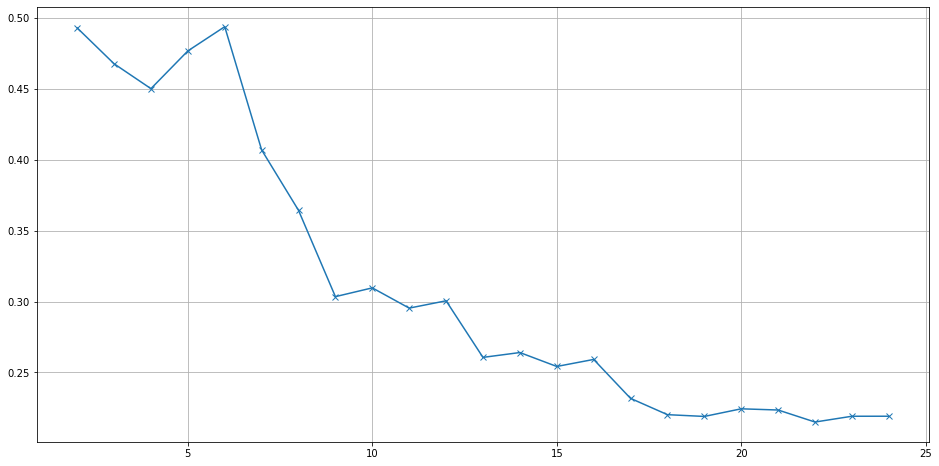

In [2383]:
silhouette_checker(AgglomerativeClustering, df_normalized)

Судя по графикам методов локтя и силуэта, оптимальное количество кластеров - 6, проводим кластеризацию:

In [2384]:
aglomer = AgglomerativeClustering(n_clusters=6)
df_normalized['aglo_cluster'] = aglomer.fit_predict(df_normalized.drop(columns=['kmeans_cluster'], axis=1))

In [2385]:
unique, counts = np.unique(df_normalized['aglo_cluster'], return_counts=True)
print(f'Количество записей каждого кластера: {dict(zip(unique, counts))}')

Количество записей каждого кластера: {0: 185, 1: 191, 2: 314, 3: 72, 4: 145, 5: 93}


Проводим кластеризацию алгоритмом DBSCAN:
Подбираем оптимальное знаение e:

Методом локтя:

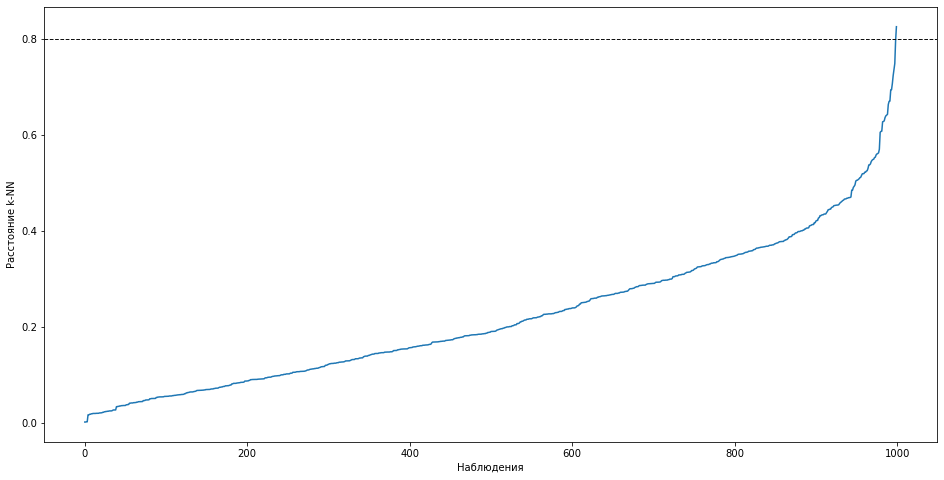

In [2386]:
nbrs = NearestNeighbors(n_neighbors=min_pts + 1).fit(df_normalized.drop(columns=['kmeans_cluster', 'aglo_cluster'], axis=1))
neigh_dist, neigh_ind = nbrs.kneighbors(df_normalized.drop(columns=['kmeans_cluster', 'aglo_cluster'], axis=1))
sort_neigh_dist = np.sort(neigh_dist, axis=0)
k_dist = sort_neigh_dist[:, 1]
plt.figure(figsize=(16, 8))
plt.plot(k_dist)
plt.axhline(y=0.8, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("Расстояние k-NN")
plt.xlabel("Наблюдения")
plt.show()

Коэффициентом силуэта:

In [2387]:
eps_list=np.arange(start=0.1, stop=1.9, step=0.1)
min_sample_list=np.arange(start=2, stop=min_pts*2, step=1)

silhouette_scores_data=pd.DataFrame()
silhouette = []
 
for eps_trial in eps_list:
    for min_sample_trial in min_sample_list:
        
        db = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        if(len(np.unique(db.fit_predict(df_normalized.drop(columns=['kmeans_cluster', 'aglo_cluster'], axis=1))))>1):
            sil_score=silhouette_score(df_normalized.drop(columns=['kmeans_cluster', 'aglo_cluster'], axis=1), db.fit_predict(df_normalized.drop(columns=['kmeans_cluster', 'aglo_cluster'], axis=1)))
        else:
            continue
        trial_parameters="eps:" + str(eps_trial.round(1)) +" min_sample:" + str(min_sample_trial)
        silhouette_scores_data = pd.concat([pd.DataFrame([[sil_score,trial_parameters]], columns=["score", "parameters"]), silhouette_scores_data], ignore_index=True)

In [2388]:
score_parameters = silhouette_scores_data.sort_values(by='score', ascending=False).head(1)
best_eps = float(score_parameters['parameters'][0].split(' ')[0].split(':')[1])
best_pts = int(score_parameters['parameters'][0].split(' ')[1].split(':')[1])
print(f'Лучшие параметры:')
print(score_parameters)

Лучшие параметры:
      score             parameters
0  0.284271  eps:1.0 min_sample:17


In [2389]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_pts)
df_normalized['dbscan_cluster'] = dbscan.fit_predict(df_normalized.drop(columns=['kmeans_cluster', 'aglo_cluster'], axis=1))

In [2390]:
unique, counts = np.unique(df_normalized['dbscan_cluster'], return_counts=True)
print(f'Количество записей каждого кластера: {dict(zip(unique, counts))}')

Количество записей каждого кластера: {0: 690, 1: 310}


Сжатие признакового пространства:

PCA

In [2391]:
plot_palette = 'viridis'

In [2392]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_normalized.drop(columns=['kmeans_cluster', 'aglo_cluster', 'dbscan_cluster'], axis=1))

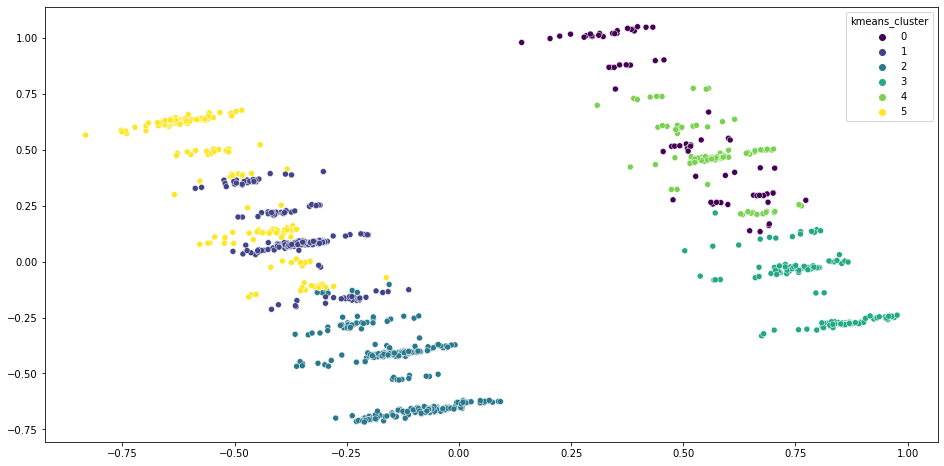

In [2393]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x = df_pca[:,0], y = df_pca[:,1], hue=df_normalized['kmeans_cluster'], palette=plot_palette);

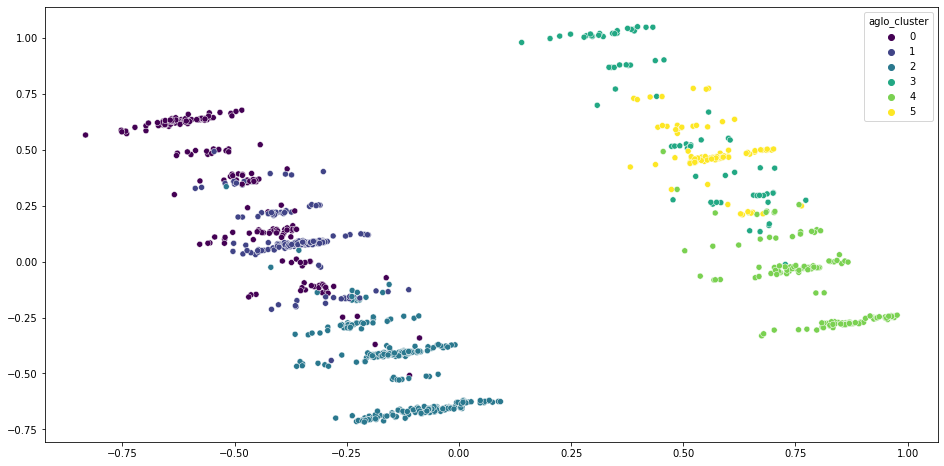

In [2394]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x = df_pca[:,0], y = df_pca[:,1], hue=df_normalized['aglo_cluster'], palette=plot_palette);

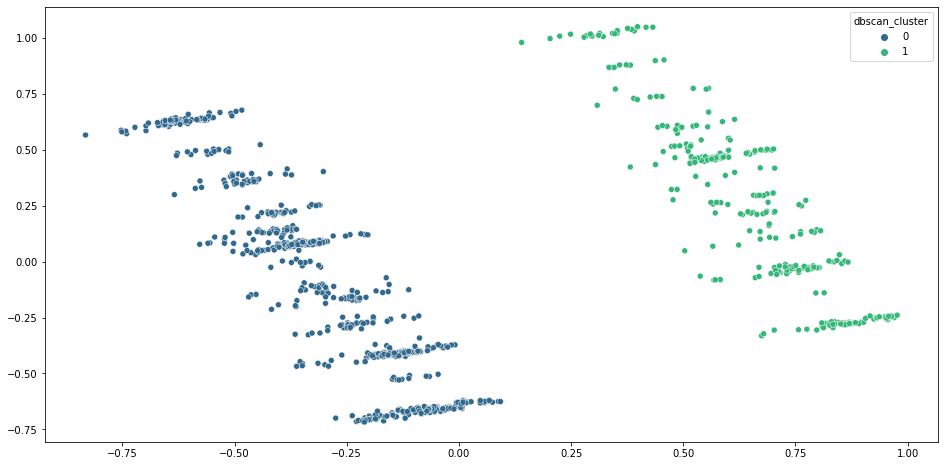

In [2395]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x = df_pca[:,0], y = df_pca[:,1], hue=df_normalized['dbscan_cluster'], palette=plot_palette);

UMAP

In [2396]:
ump = umap.UMAP(random_state=42)
df_umap = ump.fit_transform(df_normalized.drop(columns=['kmeans_cluster', 'aglo_cluster', 'dbscan_cluster'], axis=1))

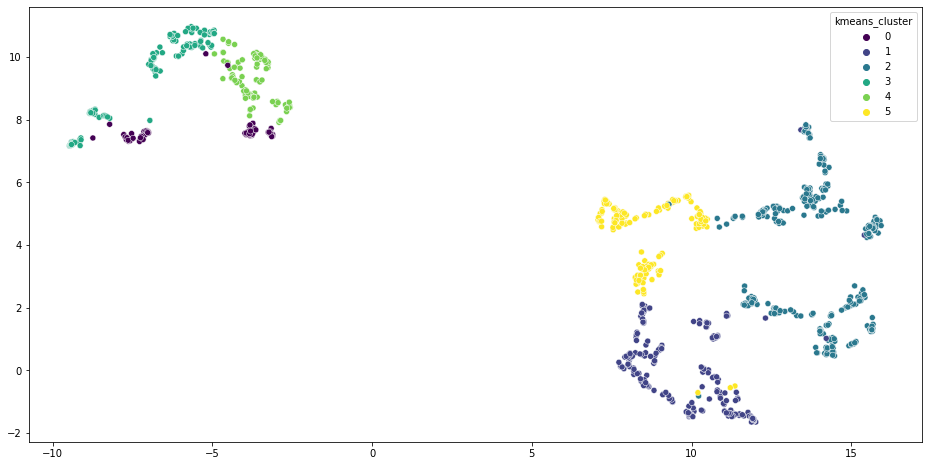

In [2397]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x = df_umap[:,0], y = df_umap[:,1], hue=df_normalized['kmeans_cluster'], palette=plot_palette);

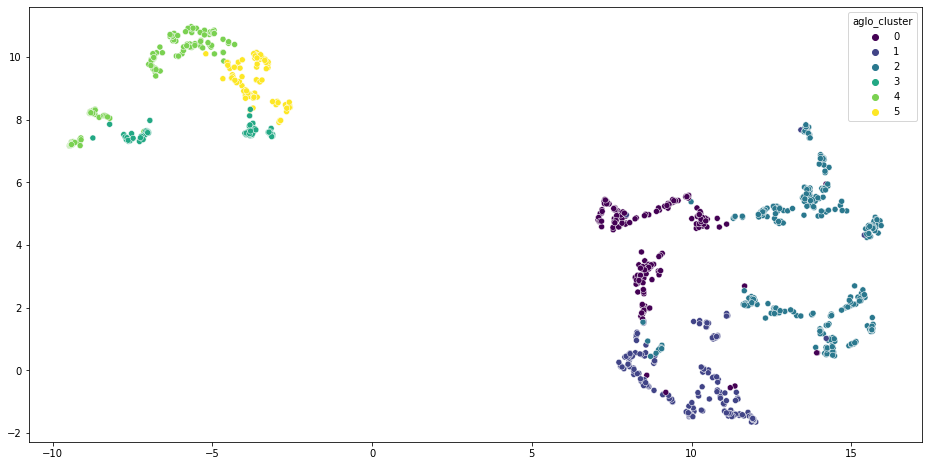

In [2398]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x = df_umap[:,0], y = df_umap[:,1], hue=df_normalized['aglo_cluster'], palette=plot_palette);

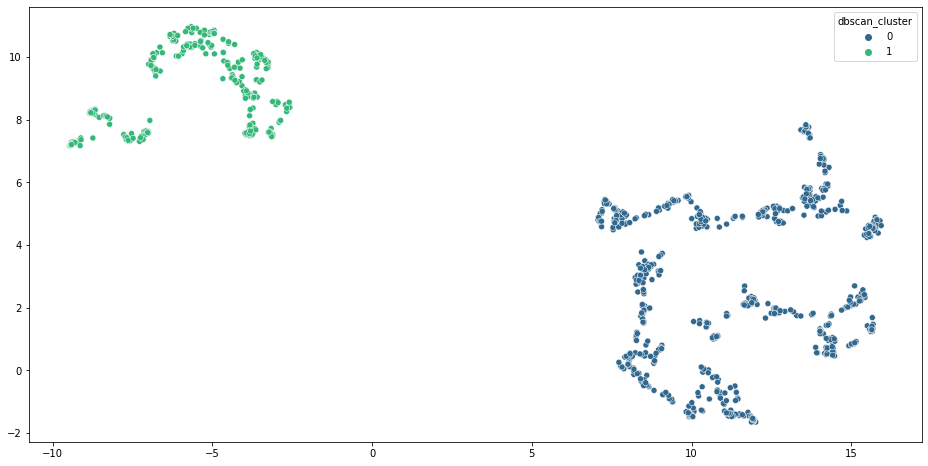

In [2399]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x = df_umap[:,0], y = df_umap[:,1], hue=df_normalized['dbscan_cluster'], palette=plot_palette);

TSNE

In [2400]:
tsne = TSNE(n_components=2, random_state=10, init='random', learning_rate='auto')
df_tsne = tsne.fit_transform(df_normalized.drop(columns=['kmeans_cluster', 'aglo_cluster', 'dbscan_cluster'], axis=1))

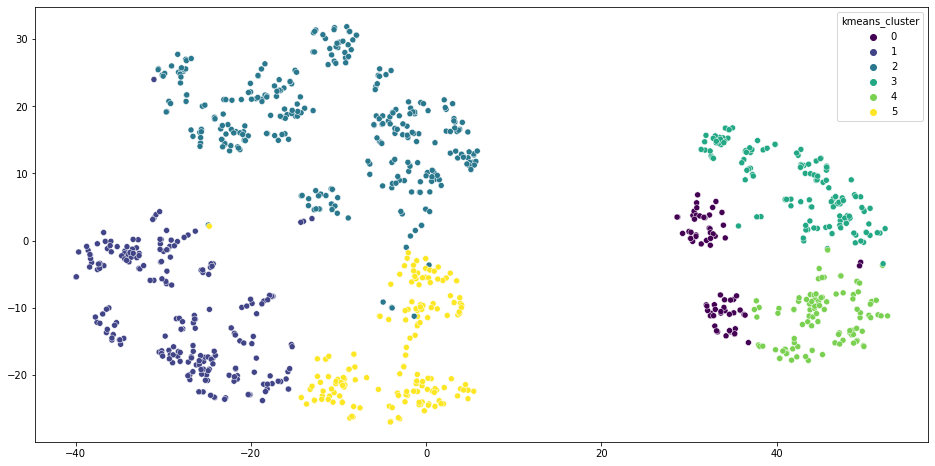

In [2401]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x = df_tsne[:,0], y = df_tsne[:,1], hue=df_normalized['kmeans_cluster'], palette=plot_palette);

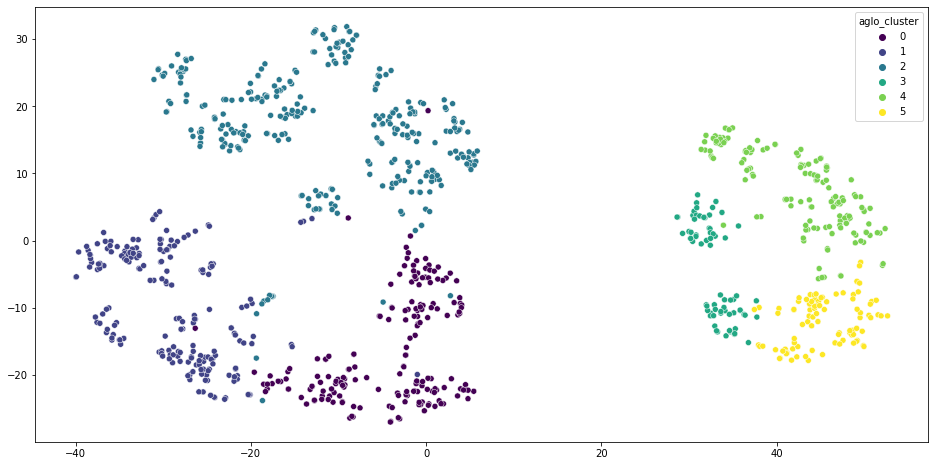

In [2402]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x = df_tsne[:,0], y = df_tsne[:,1], hue=df_normalized['aglo_cluster'], palette=plot_palette);

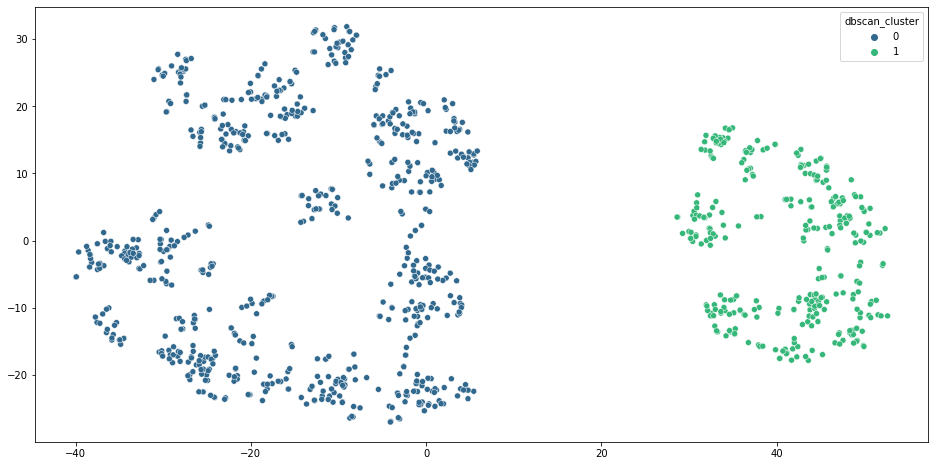

In [2403]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x = df_tsne[:,0], y = df_tsne[:,1], hue=df_normalized['dbscan_cluster'], palette=plot_palette);

Интерпретация значений:

In [2406]:
df['kmeans_cluster'] = df_normalized['kmeans_cluster']
df['aglo_cluster'] = df_normalized['aglo_cluster']
df['dbscan_cluster'] = df_normalized['dbscan_cluster']

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,kmeans_cluster,aglo_cluster,dbscan_cluster
0,67,1,2,1,4,0,1169,6,5,5,0,0
1,22,0,2,1,0,1,5951,48,5,3,4,1
2,49,1,1,1,0,3,2096,12,3,1,1,0
3,45,1,2,0,0,0,7882,42,4,2,2,0
4,53,1,2,0,0,0,4870,24,1,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,1,0,3,1736,12,4,4,5,1
996,40,1,3,1,0,0,3857,30,1,2,2,0
997,38,1,2,1,0,3,804,12,5,1,1,0
998,23,1,2,0,0,0,1845,45,5,2,2,0


K-Means:

In [2413]:
df.drop(columns=['aglo_cluster', 'dbscan_cluster'], axis=1).groupby('kmeans_cluster').mean()    #[['Age', 'Credit amount', 'Duration']]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
kmeans_cluster,,,,,,,,,
0,34.527778,0.0,1.805556,1.375000,3.625000,1.708333,2713.000000,19.111111,2.819444
1,36.691589,1.0,1.953271,1.014019,0.406542,2.864486,2849.051402,19.238318,2.981308
2,35.662379,1.0,1.916399,1.016077,0.244373,0.456592,3562.302251,22.385852,2.758842
3,32.021898,0.0,1.839416,1.233577,0.153285,0.474453,3160.167883,20.963504,3.116788
4,32.633663,0.0,1.851485,1.168317,0.346535,2.831683,2612.188119,17.603960,3.168317
5,38.993939,1.0,1.945455,0.921212,3.787879,2.109091,4009.545455,23.018182,2.618182


In [2417]:
df['kmeans_cluster'].value_counts()

2    311
1    214
5    165
3    137
4    101
0     72
Name: kmeans_cluster, dtype: int64

In [2418]:
df.drop(columns=['kmeans_cluster', 'dbscan_cluster'], axis=1).groupby('aglo_cluster').mean()    #[['Age', 'Credit amount', 'Duration']]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
aglo_cluster,,,,,,,,,
0,39.383784,1.0,1.940541,0.945946,3.578378,2.108108,3802.297297,22.367568,2.816216
1,37.015707,1.0,1.931937,1.000000,0.324607,2.879581,2733.026178,18.534031,2.743455
2,35.098726,1.0,1.933121,1.015924,0.203822,0.519108,3674.251592,22.926752,2.812102
3,33.777778,0.0,1.819444,1.361111,3.597222,1.736111,2747.958333,18.819444,2.777778
4,32.020690,0.0,1.834483,1.220690,0.165517,0.565517,3108.000000,20.682759,3.179310
5,33.268817,0.0,1.849462,1.193548,0.365591,2.870968,2619.322581,17.978495,3.107527


In [2419]:
df['aglo_cluster'].value_counts()

2    314
1    191
0    185
4    145
5     93
3     72
Name: aglo_cluster, dtype: int64

In [2420]:
df.drop(columns=['kmeans_cluster', 'aglo_cluster'], axis=1).groupby('dbscan_cluster').mean()    #[['Age', 'Credit amount', 'Duration']]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
dbscan_cluster,,,,,,,,,
0,36.778261,1.0,1.934783,0.992754,1.142029,1.598551,3448.040580,21.56087,2.794203
1,32.803226,0.0,1.835484,1.245161,1.022581,1.529032,2877.774194,19.43871,3.064516


In [2421]:
df['dbscan_cluster'].value_counts()

0    690
1    310
Name: dbscan_cluster, dtype: int64

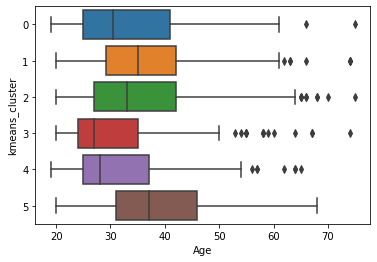

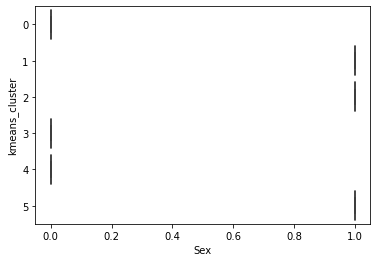

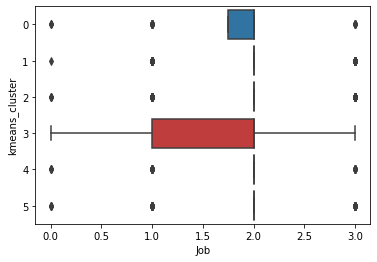

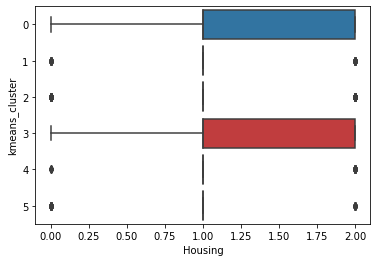

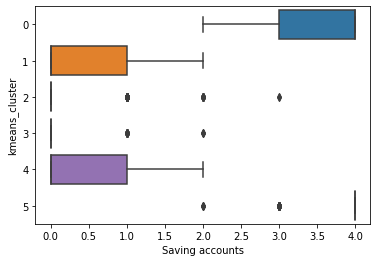

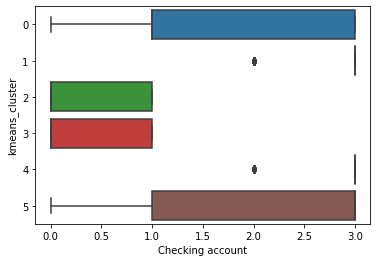

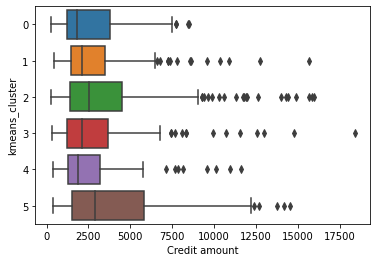

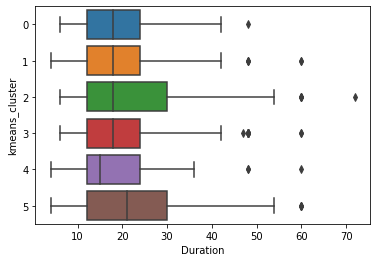

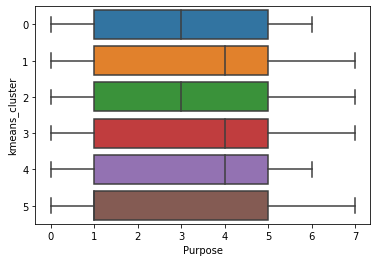

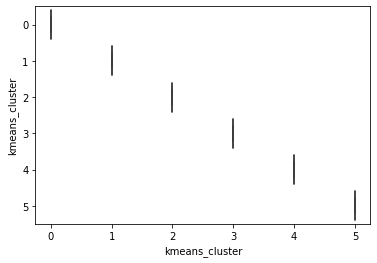

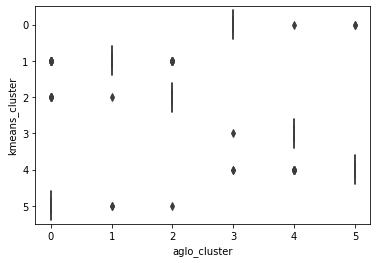

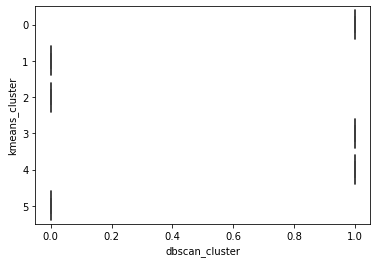

In [2423]:
for col in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=col, y=df['kmeans_cluster'], orient='h')
    plt.show();